# Part B: Regression Problem

* **Name** Acharya Atul
* **Matriculation Number** U1923502C
* **Email** atul001@e.ntu.edu.sg

# Question 1
>Real world datasets often have a mix of numeric and categorical features – this dataset is one such
example. To build models on such data, categorical features have to be encoded. Also, before
applying neural networks, it is a good practice to try simpler machine learning algorithms first.
For all models in Part B of the assignment, the following features should be used:
>- Numeric features: dist_to_nearest_stn, dist_to_dhoby, degree_centrality,
eigenvector_centrality, remaining_lease_years, floor_area_sqm
>- Categorical features: month, flat_model_type, storey_range
One-hot encoding should be applied on categorical features.
Standardisation should be performed on numeric features.

### Neccessary Imports

* **pandas** - Data analysis and manipulation
* **tensorflow** - Modeling neural networks and training them
* **graphviz** - Visualization of model architecture

In [1]:
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

import graphviz
from keras.utils.vis_utils import plot_model

### Setting the seed for reproducability

>For this assignment we will be using 42 as the seed

In [2]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

### Reading dataset

In [3]:
df = pd.read_csv('../input/assignment/hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


### Functions to create our dataset and encode features

In [4]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


### Function to compute $R^2$ score
>$R^2$ = 1 - $\dfrac{\Sigma_i(y_i - \hat{y_i})} {\Sigma_i(y_i - \bar{y_i})}$

In [5]:
from keras import backend as K

def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Part A
>Divide the dataset (‘HDB_price_prediction.csv’) into train and test sets by using
entries from year 2020 and before as training data (with the remaining data from
year 2021 and 2022 used as test data). 

### Splitting Data
>All datapoints until the year 2020 belong in the train set and all datapoints from year 2021 and onwards belong to the test set

#### Reason
>Our aim in this task is to predict the resale prices of houses in the future. Hence, we need to forcast future values that come in later years and we train on older samples and predict on newer samples. This gives us a better idea as to how the model would perform when deployed into the real world where data keeps changing over time

In [6]:
# Split data

train_dataframe = df[df['year'] <= 2020]
test_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

# Grouping data into batches
batch_size = 256
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)


2022-10-10 12:27:55.405478: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Part B
>A team of data scientists has implemented a linear regression model via Scikitlearn. They obtained a test **$R^2$ value of 0.627** and happily shared with you that their
model only took a few seconds to train. They suggest you to try out an equivalent
deep learning model to see if you get a similar result. Recall that a linear regression
model is equivalent to a neural network with only 1 Dense layer (i.e. no hidden
layer) with linear activation and 1 output node

### Creating Input Layer
> All categorical features are encoded during the forward propagation and All numerical features are normalized using the statistics of the training dataset

In [7]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)


# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")

dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

# Raw input features
all_inputs = [
    month,
    storey_range,
    flat_model_type,
    floor_area_sqm,
    remaining_lease_years,
    degree_centrality,
    eigenvector_centrality,
    dist_to_nearest_stn,
    dist_to_dhoby,
]

# Encoded features
all_features = layers.concatenate(
    [
        month_encoded,
        storey_range_encoded,
        flat_model_type_encoded,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
    ]
)

2022-10-10 12:27:55.979262: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### Defining model architecture
>The architecture below defines a Linear Regression model where the encoded features passes through a dense layer with 1 neuron which is also the output neuron. This neuron has a linear activation function.

In [8]:
dense_layer = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, dense_layer)

### Plot of Model Architecture

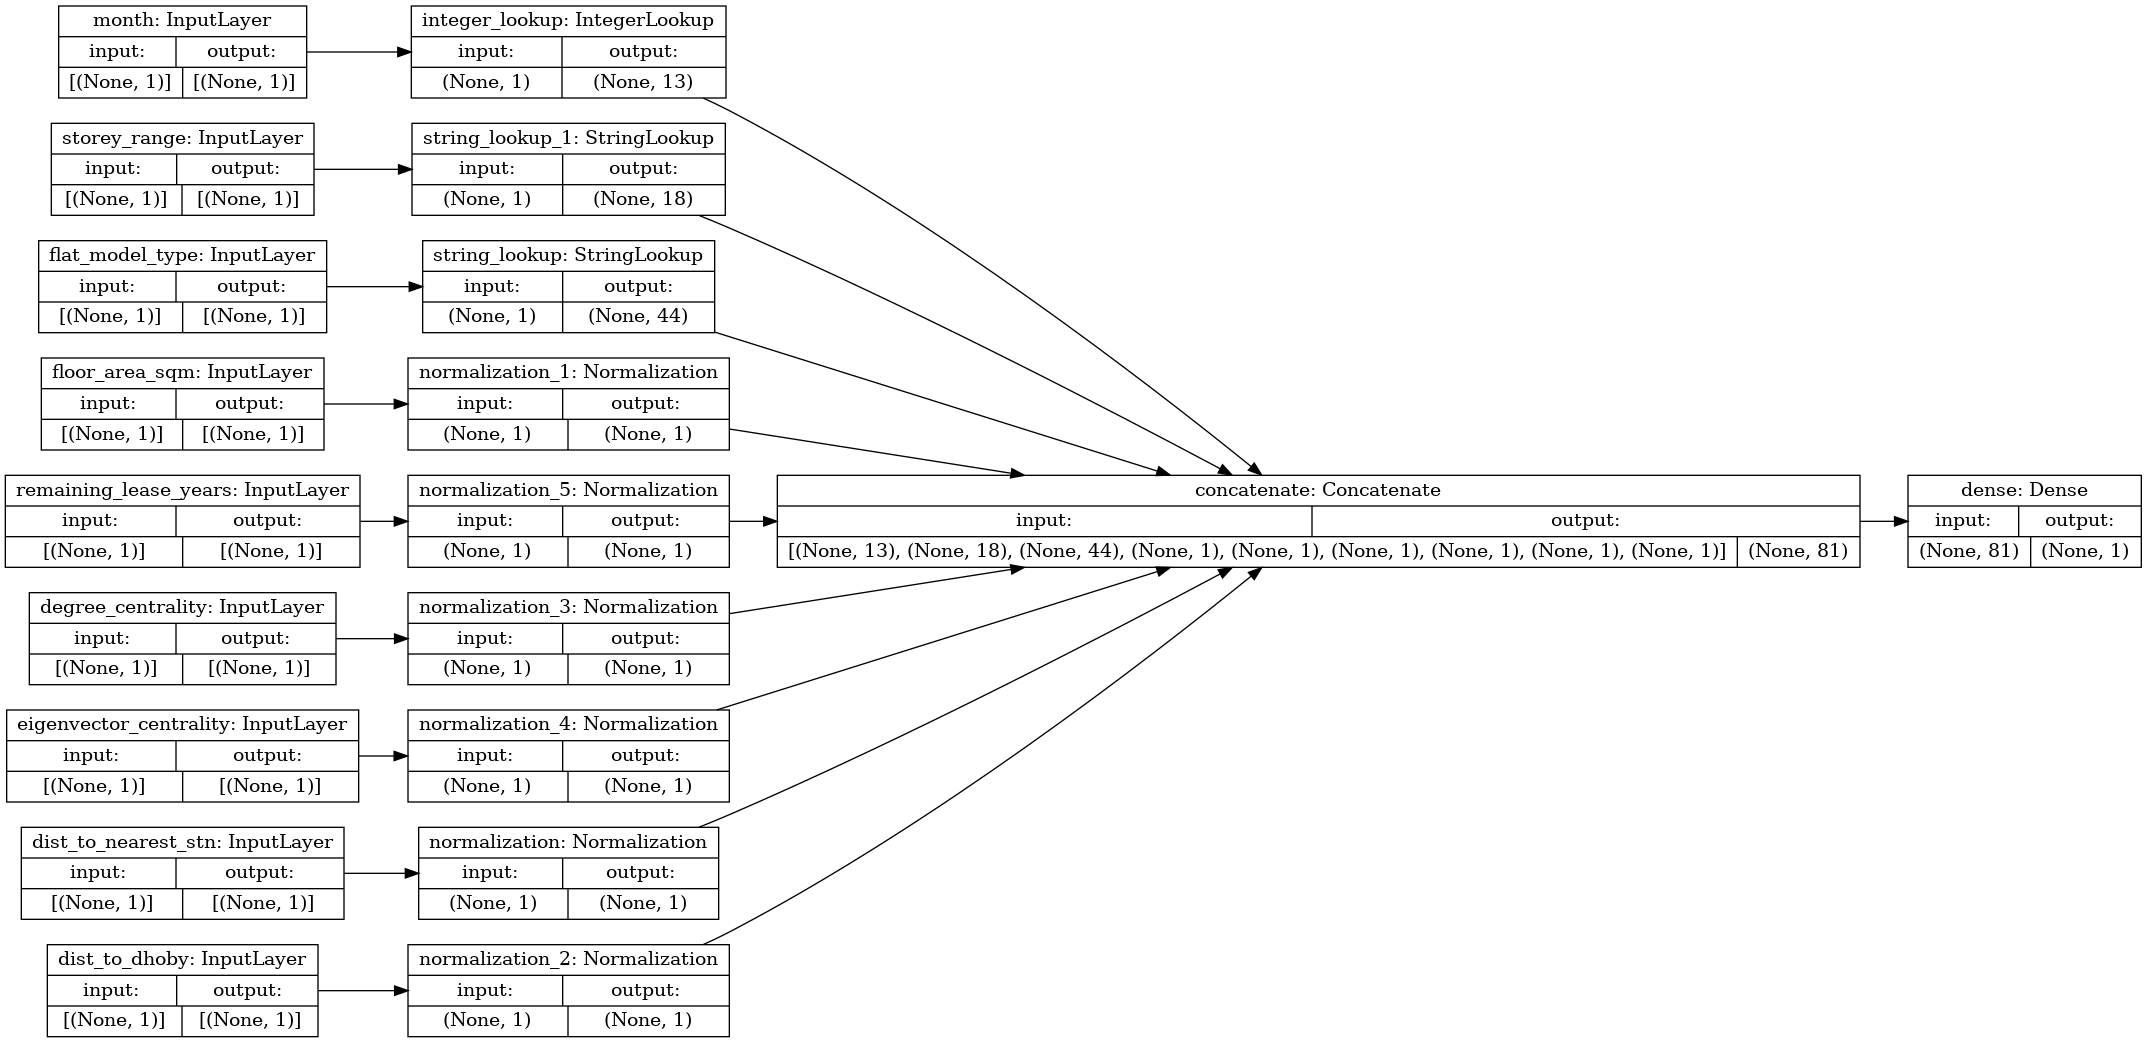

In [9]:
plot_model(model, show_shapes=True, rankdir="LR")

## Part C
>The team suggests you to train the model for 50 epochs using mini-batch gradient
descent with batch size = 256, Adam optimiser (with a default learning rate of 𝛼 =
0.001) and mean square error as cost function. However, you find that your results
are far off from their model. Change the optimiser to SGD (with default learning rate
of 𝛼 = 0.01) and observe how the problem gets fixed. Report the test R
2 value and
explain why the change to SGD fixes the problem faced when using Adam optimiser.<br>
(Hint: Look carefully at how Adam is implemented and see how SGD is different.)

### Defining Optimizer and Compiling Model

In [10]:
opt=keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError(), r2])

### Model Training

In [11]:
history = model.fit(train_ds, epochs=50, validation_data=test_ds)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


342/342 [==============================] - 5s 10ms/step - loss: 219585921024.0000 - mean_squared_error: 219585921024.0000 - r2: -8.3474 - val_loss: 301486735360.0000 - val_mean_squared_error: 301486735360.0000 - val_r2: -10.0832
Epoch 2/50
342/342 [==============================] - 3s 8ms/step - loss: 219584561152.0000 - mean_squared_error: 219584561152.0000 - r2: -8.3520 - val_loss: 301485064192.0000 - val_mean_squared_error: 301485064192.0000 - val_r2: -10.0722
Epoch 3/50
342/342 [==============================] - 3s 8ms/step - loss: 219583217664.0000 - mean_squared_error: 219583217664.0000 - r2: -8.3501 - val_loss: 301483458560.0000 - val_mean_squared_error: 301483458560.0000 - val_r2: -10.1026
Epoch 4/50
342/342 [==============================] - 3s 8ms/step - loss: 219581890560.0000 - mean_squared_error: 219581890560.0000 - r2: -8.3437 - val_loss: 301481951232.0000 - val_mean_squared_error: 301481951232.0000 - val_r2: -10.0800
Epoch 5/50
342/342 [==============================] - 

### Test $R^2$ Linear Regression with Adam

In [12]:
print(f"test R2 value: {history.history['val_r2'][-1]}")

test R2 value: -10.07387924194336


### Observations
>The test $R^2$ value is below 0 which means the model does not follow the trend of the data and its performance is very bad

### Switching Optimizer to SGD

In [13]:
dense_layer = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, dense_layer)
opt=keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError(), r2])
history = model.fit(train_ds, epochs=50, validation_data=test_ds)

Epoch 1/50
342/342 [==============================] - 5s 10ms/step - loss: 18728673280.0000 - mean_squared_error: 18728673280.0000 - r2: 0.1966 - val_loss: 13789992960.0000 - val_mean_squared_error: 13789992960.0000 - val_r2: 0.4958
Epoch 2/50
342/342 [==============================] - 4s 9ms/step - loss: 5481924096.0000 - mean_squared_error: 5481924096.0000 - r2: 0.7678 - val_loss: 12796292096.0000 - val_mean_squared_error: 12796292096.0000 - val_r2: 0.5320
Epoch 3/50
342/342 [==============================] - 4s 9ms/step - loss: 5026647040.0000 - mean_squared_error: 5026647040.0000 - r2: 0.7875 - val_loss: 12325083136.0000 - val_mean_squared_error: 12325083136.0000 - val_r2: 0.5501
Epoch 4/50
342/342 [==============================] - 4s 9ms/step - loss: 4776961536.0000 - mean_squared_error: 4776961536.0000 - r2: 0.7976 - val_loss: 12102071296.0000 - val_mean_squared_error: 12102071296.0000 - val_r2: 0.5574
Epoch 5/50
342/342 [==============================] - 4s 9ms/step - loss: 460

### Test $R^2$ Linear Regression with SGD

In [14]:
print(f"test R2 value: {history.history['val_r2'][-1]}")

test R2 value: 0.6100942492485046


### Observations
>The test $R^2$ value using SGD optimizer is much better and seems to fix the problem.

### Inference
Adam optimizer involves a combination of two gradient descent methodologies: 
* **Momentum**: This algorithm is used to accelerate the gradient descent algorithm by taking into consideration the ‘exponentially weighted average’ of the gradients. Using averages makes the algorithm converge towards the minima in a faster pace. <br>
$w_{t+1} = w_t - \alpha m_t$<br>
$where$ $m_t = \beta_1 m_{t-1} + (1-\beta_1) \dfrac{\partial L}{\partial w_t}$

* **Root Mean Square Propagation (RMSP)**: Root mean square prop or RMSprop is an adaptive learning algorithm that tries to improve AdaGrad. Instead of taking the cumulative sum of squared gradients like in AdaGrad, it takes the ‘exponential moving average’.
$w_{t+1} = w_t - \dfrac{\alpha_t}{\sqrt{v_t + \epsilon}} \dfrac{\partial L}{\partial w_t} $<br>
$where$ $v_t = \beta_2 v_{t-1} + (1-\beta_2) (\dfrac{\partial L}{\partial w_t})^2$

Adam can suffer a weight decay problem. Weight decay works by adding a penalty term to the cost function of a neural network which has the effect of shrinking the weights during backpropagation. This helps prevent the network from overfitting the training data but in our case it seems to be underfitting and the model is not able to learn a good approximation function for our dataset. Moreover, Adam gives a higher priority to previous gradients and tries to make gradient updates in this direction and hence its hard to recover once we start underfitting.

Stochastic gradient descent on the other hand has some randomness or noise which allows to escape from local minima to reach a better minimum.
<br>.Moreover, it doesn't suffer from weight decay and is able to learn a good function approximator. <br>
$w_{t+1} = w_t - \alpha \dfrac{\partial L}{\partial w_t}$

## Part D
>Add 1 hidden layer (10 units) to the architecture in Q1c and train it with the same
configuration as in Q1c (i.e. with Adam) except that the learning rate is increased to
0.08. Report the test R
2 value.

### Definition of Model Architecture
>Nothing was mentioned about the activation function so I used ReLU

In [15]:
hidden_layer = layers.Dense(10, activation="relu")(all_features)
dense_layer = layers.Dense(1, activation="linear")(hidden_layer)
model = keras.Model(all_inputs, dense_layer)
opt=keras.optimizers.Adam(learning_rate=0.08)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError(), r2])
history = model.fit(train_ds, epochs=50, validation_data=test_ds)

Epoch 1/50
342/342 [==============================] - 5s 10ms/step - loss: 202138501120.0000 - mean_squared_error: 202138501120.0000 - r2: -7.5969 - val_loss: 234665263104.0000 - val_mean_squared_error: 234665263104.0000 - val_r2: -7.6305
Epoch 2/50
342/342 [==============================] - 4s 9ms/step - loss: 108115525632.0000 - mean_squared_error: 108115525632.0000 - r2: -3.6036 - val_loss: 99724115968.0000 - val_mean_squared_error: 99724115968.0000 - val_r2: -2.6657
Epoch 3/50
342/342 [==============================] - 4s 9ms/step - loss: 28253134848.0000 - mean_squared_error: 28253134848.0000 - r2: -0.1999 - val_loss: 29892052992.0000 - val_mean_squared_error: 29892052992.0000 - val_r2: -0.0934
Epoch 4/50
342/342 [==============================] - 4s 10ms/step - loss: 7283666944.0000 - mean_squared_error: 7283666944.0000 - r2: 0.6924 - val_loss: 14998016000.0000 - val_mean_squared_error: 14998016000.0000 - val_r2: 0.4524
Epoch 5/50
342/342 [==============================] - 4s 9ms

### Test $R^2$ with 1 hidden layer

In [16]:
print(f"test R2 value: {history.history['val_r2'][-1]}")

test R2 value: 0.6628679633140564


## Part E
>Compare the performance of the linear regression model to the Dense layer (Q1c)
and the NN architecture (Q1d) and suggest reasons for the observations you made.

### Answer
The Linear Regression Model performs slightly better that the Dense Layer in Q1c but the Neural Network architecture defined in Q1d performs better that the Linear Regression Model

The Neural Network learns better features and can handle non-linearity due to the hidden layer. This makes it a better function approximator that the Linear Regression  Model.

The Linear Regression Model and the Dense Layer have similar performace and the Linear Regression model is slightly better. However, with hyperparameter tuning of the Dense Layer (Batch Size and Learning Rate), the Dense Layer might give a higher score and could perform on par with the Linear Regression Model
